First run I will do without any filtering, that might come later after a deeper investigation in possible filters.

In [1]:
%run ../scripts/notebook_settings.py

In [2]:
meta_data_samples = pd.read_table("../data/metadata_with_x_missing.txt", sep=" ")

In [3]:
zarr_dir = "/faststorage/project/baboondiversity/data/PG_panu3_zarr_12_03_2021/callset.zarr/chrX"
#Opening the zarr data
callset = zarr.open_group(zarr_dir, mode="r")
gt = allel.GenotypeArray(callset["calldata/GT"])

Filter gt for biallelic sites

In [4]:
ac = gt.count_alleles()[:] #Allele counts for each pos
flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1) #Filter for biallelic and presence of alternate
gf = gt.compress(flt, axis=0)
pos = (callset["variants/POS"][:]).compress(flt, axis=0)
print(len(gf), len(gt), len(gf)/len(gt))

2560187 2923212 0.8758129755898648


First, I am going to find shared derived between Species, and then between the clustered origins.
First for the whole X (including PAR here), then for regions

In [5]:
id_dir = {}
for s in meta_data_samples.Species.unique():
    IDs = meta_data_samples.loc[(meta_data_samples.Species == s)
                                      & (meta_data_samples.Sex == "F")
                                    & (meta_data_samples.C_origin != "Anubis, Kenya")].callset_index.values
    if len(IDs) != 0:
        id_dir[s] = IDs

In [6]:
id_dir

{'cynocephalus': array([  0,   1,  24,  25,  27,  35,  36,  37,  43,  48,  61,  62,  63,
         87, 104, 105, 177, 186, 197, 201, 202, 204, 205, 206]),
 'anubis': array([ 10,  11,  14,  16,  17,  19,  20,  21,  22,  23,  30,  32,  33,
         49,  50,  51,  52,  54,  55,  56,  76,  79,  83,  84,  85,  90,
         91,  93,  95,  97,  99, 100, 101, 106, 107, 108, 109, 110, 112,
        114, 115, 117, 118, 153, 156, 158, 162, 168, 169, 170, 176]),
 'kindae': array([  4,   5, 192, 213, 220, 221, 222, 223, 224]),
 'hamadryas': array([  7, 130, 132, 133, 140, 142]),
 'papio': array([64, 65, 66, 67, 68]),
 'ursinus (grayfoot)': array([125, 126, 127])}

Creating the dataframe and populating it

In [7]:
df_species = pd.DataFrame()
df_species["pos"] = pos
for species in id_dir:
    print(species)
    IDs = id_dir[species]
    gt_species = gf.take(IDs, axis=1)
    ac = gt_species.count_alleles()
    df_species[species] = ac.is_variant()
    print(ac.is_variant().sum())

cynocephalus
1019939
anubis
766536
kindae
578411
hamadryas
355074
papio
185075
ursinus (grayfoot)
410758


Number of sites with no derived (due to males having derived calls)

In [8]:
print((df_species.iloc[:,1:].sum(axis=1) == 0).sum()/len(df_species))

0.31801348885843106


Looking at the distribution of derived sites

In [9]:
df_species["species_derived"] = df_species.iloc[:,1:].sum(axis=1)

In [10]:
df_species["species_derived"].value_counts()

1    1014986
0     814174
2     348618
3     137993
4     107343
6      74855
5      62218
Name: species_derived, dtype: int64

<AxesSubplot:xlabel='species_derived', ylabel='Count'>

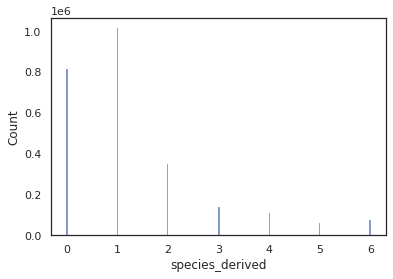

In [11]:
sns.histplot(df_species, x="species_derived")

In [12]:
df_species_r = df_species.loc[df_species.species_derived != 6]

In [13]:
d_d = {}
for s1 in id_dir:
    d_d[s1] = {}
    for s2 in id_dir:
        d_d[s1][s2] =((df_species_r[s1]==True) & (df_species_r[s2]==True)).sum()
derived_df = pd.DataFrame(d_d)
derived_df

,cynocephalus,anubis,kindae,hamadryas,papio,ursinus (grayfoot)
cynocephalus,945084,376245,334401,108877,35120,241739
anubis,376245,691681,190337,143730,39792,159625
kindae,334401,190337,503556,78317,21035,200863
hamadryas,108877,143730,78317,280219,24367,61020
papio,35120,39792,21035,24367,110220,13367
ursinus (grayfoot),241739,159625,200863,61020,13367,335903


In [14]:
window_size = 100000
def shared_counting(shared):
    return shared.sum()

df_dict = {}
for s1 in id_dir:
    df_species_list = []
    for s2 in id_dir:
        chrom="chrX"
        shared =((df_species_r[s1]==True) & (df_species_r[s2]==True))
        pos_subset = pos.compress(df_species.species_derived != 6,axis=0)
        nnz, windows, counts = allel.windowed_statistic(pos_subset,
                                                        shared, statistic=shared_counting, size=window_size)
        df = pd.DataFrame()
        df["shared"] = nnz
        window_numbering = []
        df.insert(0, column="chrom", value=chrom)
        window_numbering.extend(range(len(nnz)))
        df.insert(1, column="start", value=window_numbering)
        df.insert(2, column = "pop", value = s2)
        df_species_list.append(df)
    s1_df = pd.concat(df_species_list, axis=0)
    df_dict[s1] = s1_df

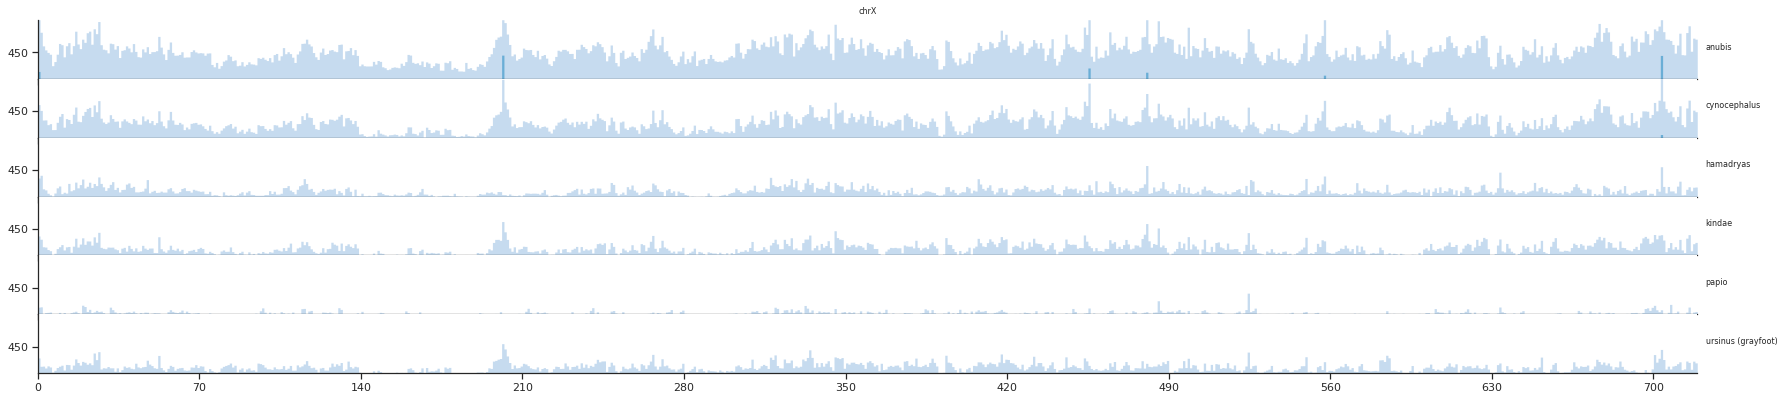

In [15]:
anubis = df_dict["anubis"]
anubis_first_half = anubis.loc[anubis.start <= max(anubis.start)//2]
fig = horizonplot(anubis_first_half, 'shared', width=1, col='chrom', row='pop', size=1, aspect=25, cut=1000)

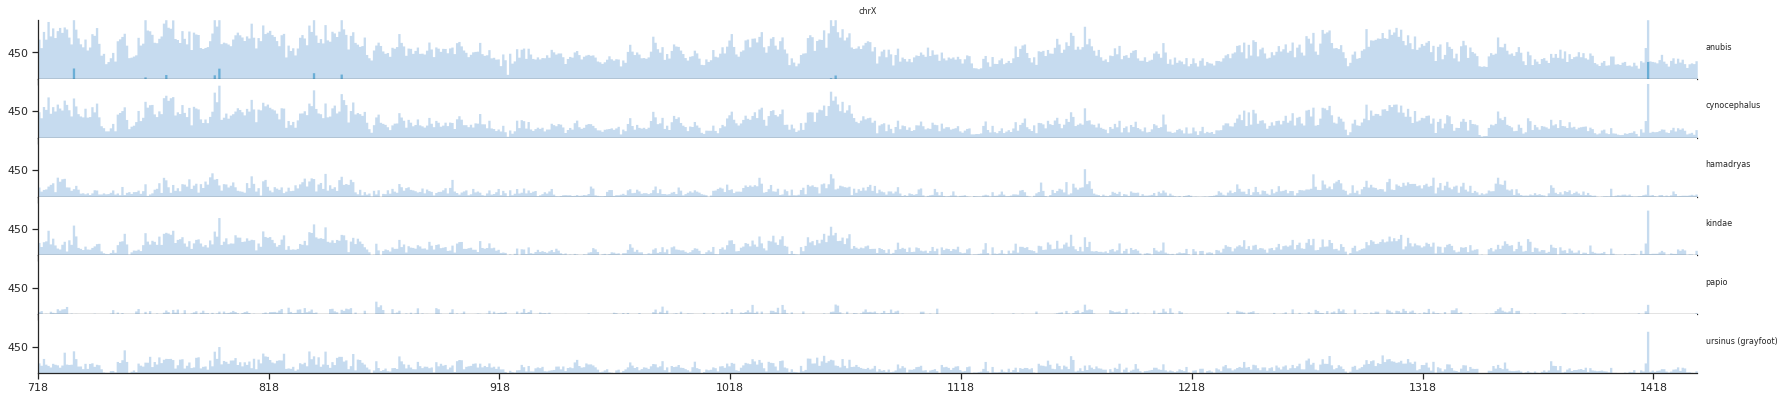

In [16]:
anubis = df_dict["anubis"]
anubis_second_half = anubis.loc[anubis.start >= max(anubis.start)//2]
fig = horizonplot(anubis_second_half, 'shared', width=1, col='chrom', row='pop', size=1, aspect=25, cut=1000)

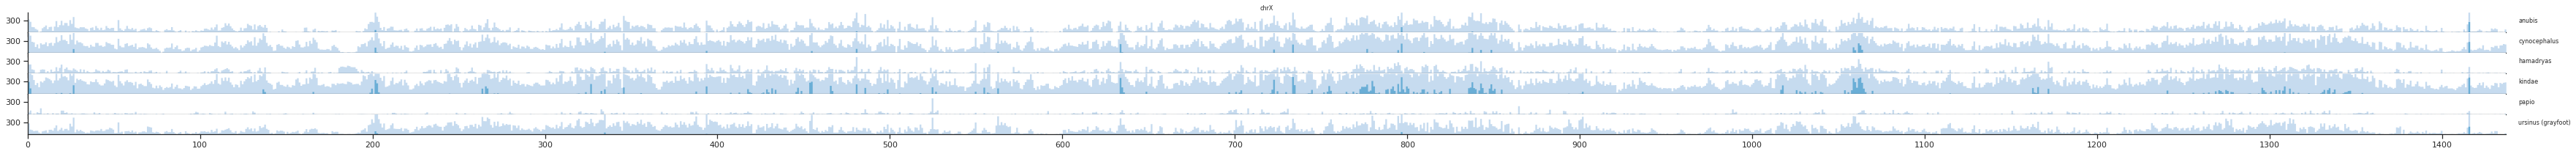

In [17]:
fig = horizonplot(df_dict["kindae"], 'shared', width=1, col='chrom', row='pop', size=0.5, aspect=100, cut=500)

Doing the same, but for the regions

In [18]:
id_dir_region = {}
for r in meta_data_samples.C_origin.unique():
    IDs = meta_data_samples.loc[(meta_data_samples.C_origin == r)
                                      & (meta_data_samples.Sex == "F")
                                      & (meta_data_samples.C_origin != "Anubis, Kenya")].callset_index.values
    if len(IDs) != 0:
        id_dir_region[r] = IDs

In [19]:
id_dir_region

{'Cynocephalus, Central Tanzania': array([  0,   1,  24,  25,  27,  35,  36,  37,  48,  61,  62,  63,  87,
        177, 186, 197, 201, 202, 204, 205, 206]),
 'Kindae, Zambia': array([  4,   5, 192, 213, 220, 221, 222, 223, 224]),
 'Hamadryas, Ethiopia': array([  7, 130, 132, 133, 140, 142]),
 'Anubis, Tanzania': array([ 10,  11,  14,  16,  17,  19,  20,  21,  22,  23,  30,  32,  33,
         49,  50,  51,  52,  54,  55,  56,  76,  79,  83,  84,  85,  90,
         91,  93,  95,  97,  99, 100, 101, 106, 107, 108, 109, 110, 112,
        114, 115, 117, 118]),
 'Cynocephalus, Western Tanzania': array([ 43, 104, 105]),
 'Papio, Senegal': array([64, 65, 66, 67, 68]),
 'Ursinus, Zambia': array([125, 126, 127]),
 'Anubis, Ethiopia': array([153, 156, 158, 162, 168, 169, 170, 176])}

In [20]:
df_region = pd.DataFrame()
df_region["pos"] = pos
for region in id_dir_region:
    print(region)
    IDs = id_dir_region[region]
    gt_region = gf.take(IDs, axis=1)
    ac = gt_region.count_alleles()
    df_region[region] = ac.is_variant()
    print(ac.is_variant().sum())
df_region["non_ref_sum"] = df_region.iloc[:,1:].sum(axis=1)

Cynocephalus, Central Tanzania
864233
Kindae, Zambia
578411
Hamadryas, Ethiopia
355074
Anubis, Tanzania
650231
Cynocephalus, Western Tanzania
547103
Papio, Senegal
185075
Ursinus, Zambia
410758
Anubis, Ethiopia
310132


In [21]:
print((df_region.iloc[:,1:].sum(axis=1) == 0).sum()/len(df_region))

0.31801348885843106


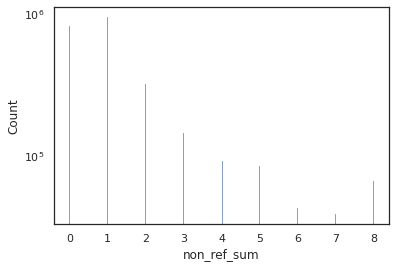

In [22]:
g = sns.histplot(df_region, x="non_ref_sum")
g.set_yscale("log")

In [23]:
len(df_region.loc[df_region.non_ref_sum ==3])

145463

In [24]:
len(df_region)

2560187

In [25]:
pd.DataFrame(df_region["non_ref_sum"].value_counts()).sort_index()

,non_ref_sum
0,814174
1,950532
2,322089
3,145463
4,92613
5,85767
6,43371
7,39019
8,67159


In [26]:
df_region_r = df_region.loc[df_region.non_ref_sum != max(df_region.non_ref_sum)]

In [27]:
pd.set_option("display.precision", 2)
d_d = {}
for s1 in sorted(id_dir_region):
    d_d[s1] = {}
    total_non_ref = (df_region_r[s1]==True).sum()
    d_d[s1]["n"] = len(id_dir_region[s1])
    d_d[s1]["Total non-ref"] = total_non_ref
    for s2 in sorted(id_dir_region):
        d_d[s1][s2] =((df_region_r[s1]==True) & (df_region_r[s2]==True)).sum()/total_non_ref
derived_df_region = pd.DataFrame(d_d)
derived_df_region

,"Anubis, Ethiopia","Anubis, Tanzania","Cynocephalus, Central Tanzania","Cynocephalus, Western Tanzania","Hamadryas, Ethiopia","Kindae, Zambia","Papio, Senegal","Ursinus, Zambia"
n,8.00,43.00,21.00,3.00,6.00,9.00,5.00,3.00
Total non-ref,242973.00,583072.00,797074.00,479944.00,287915.00,511252.00,117916.00,343599.00
"Anubis, Ethiopia",1.00,0.22,0.10,0.14,0.36,0.11,0.25,0.13
"Anubis, Tanzania",0.52,1.00,0.43,0.49,0.43,0.37,0.38,0.47
"Cynocephalus, Central Tanzania",0.34,0.58,1.00,0.68,0.37,0.52,0.33,0.65
"Cynocephalus, Western Tanzania",0.28,0.40,0.41,1.00,0.31,0.58,0.27,0.59
"Hamadryas, Ethiopia",0.42,0.21,0.14,0.19,1.00,0.17,0.27,0.20
"Kindae, Zambia",0.24,0.33,0.33,0.62,0.30,1.00,0.24,0.61
"Papio, Senegal",0.12,0.08,0.05,0.07,0.11,0.06,1.00,0.06
"Ursinus, Zambia",0.19,0.28,0.28,0.42,0.24,0.41,0.18,1.00


In [28]:
window_size = 100000
def shared_counting(shared):
    return shared.sum()

df_dict = {}
for s1 in sorted(id_dir_region):
    df_species_list = []
    for s2 in sorted(id_dir_region):
        chrom="chrX"
        shared =((df_region_r[s1]==True) & (df_region_r[s2]==True))
        pos_subset = pos.compress(df_region_r.non_ref_sum != max(df_region.non_ref_sum),axis=0)
        nnz, windows, counts = allel.windowed_statistic(pos_subset,
                                                        shared, statistic=shared_counting, size=window_size)
        df = pd.DataFrame()
        df["shared"] = nnz
        window_numbering = []
        df.insert(0, column="chrom", value=chrom)
        window_numbering.extend(range(len(nnz)))
        df.insert(1, column="start", value=window_numbering)
        df.insert(2, column = "pop", value = s2)
        df_species_list.append(df)
    s1_df = pd.concat(df_species_list, axis=0)
    df_dict[s1] = s1_df

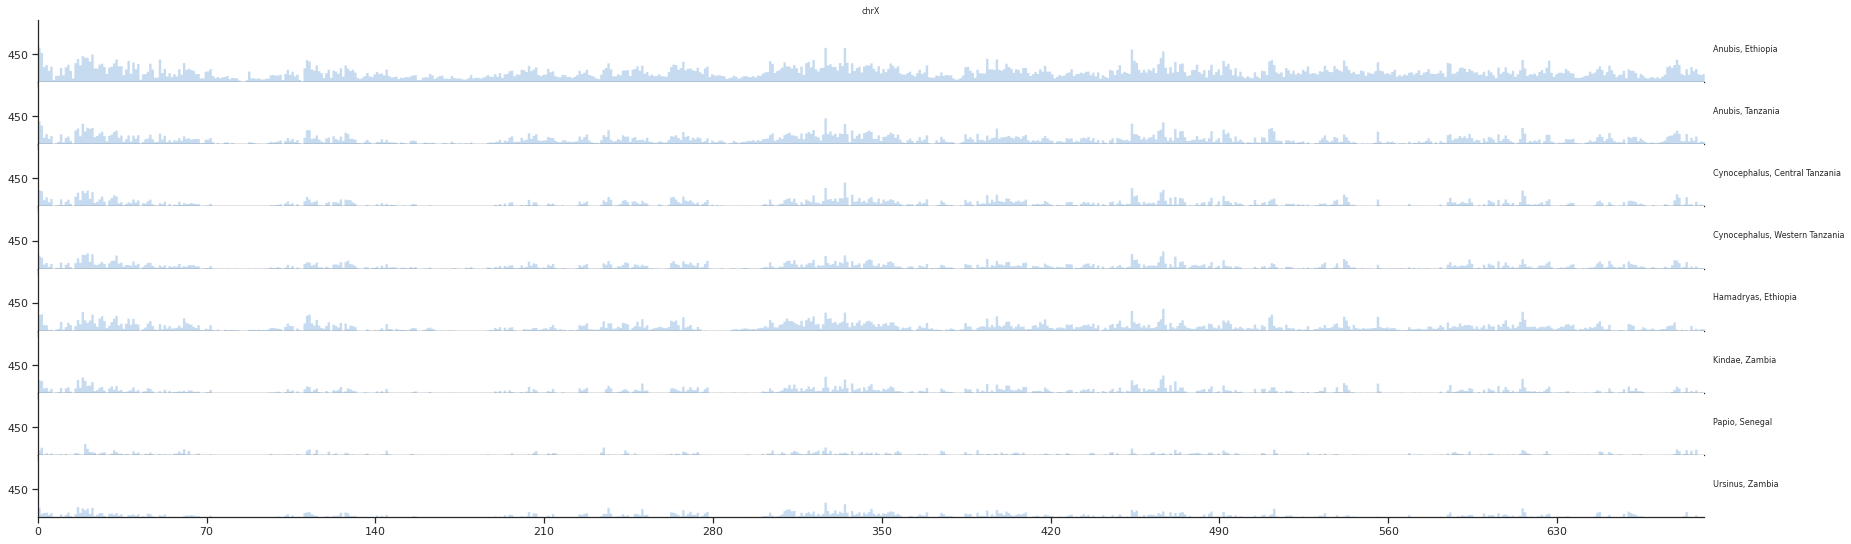

In [29]:
anubis = df_dict["Anubis, Ethiopia"]
anubis_first_half = anubis.loc[anubis.start <= max(anubis.start)//2]
fig = horizonplot(anubis_first_half, 'shared', width=1, col='chrom', row='pop', size=1, aspect=25, cut=1000)

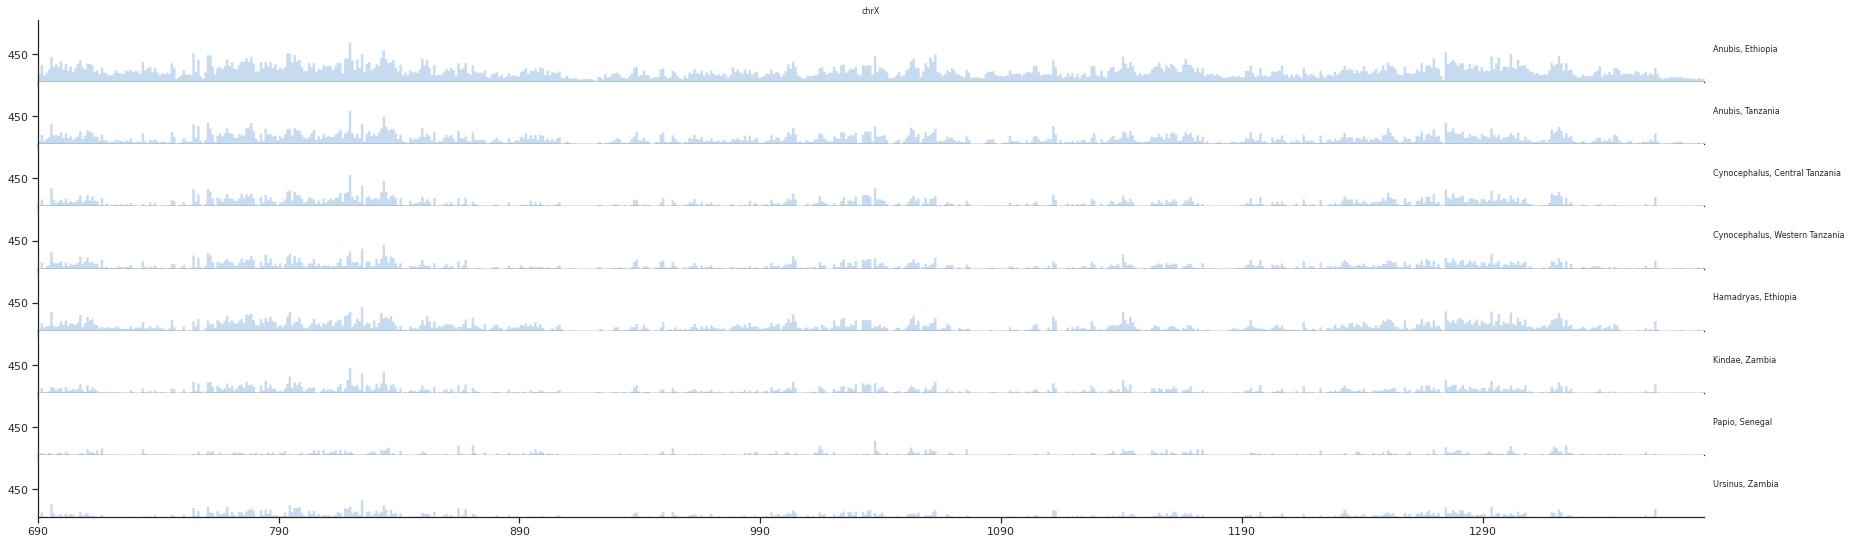

In [30]:
anubis = df_dict["Anubis, Ethiopia"]
anubis_second_half = anubis.loc[anubis.start >= max(anubis.start)//2]
fig = horizonplot(anubis_second_half, 'shared', width=1, col='chrom', row='pop', size=1, aspect=25, cut=1000)

In [40]:
df_region_r = df_region.loc[df_region.non_ref_sum == 2]

In [41]:
df_region_r

,pos,"Cynocephalus, Central Tanzania","Kindae, Zambia","Hamadryas, Ethiopia","Anubis, Tanzania","Cynocephalus, Western Tanzania","Papio, Senegal","Ursinus, Zambia","Anubis, Ethiopia",non_ref_sum
6,240,False,True,False,True,False,False,False,False,2
17,551,True,False,False,True,False,False,False,False,2
21,597,False,False,False,True,False,False,False,True,2
23,622,True,False,False,True,False,False,False,False,2
34,1454,False,False,False,True,False,False,False,True,2
...,...,...,...,...,...,...,...,...,...,...
2560161,143688922,False,False,False,True,False,True,False,False,2
2560170,143690405,False,True,False,True,False,False,False,False,2
2560175,143691435,True,False,False,True,False,False,False,False,2
2560176,143691466,False,False,False,False,True,False,True,False,2


In [42]:
pd.set_option("display.precision", 2)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
d_d = {}
for s1 in sorted(id_dir_region):
    d_d[s1] = {}
    total_non_ref = (df_region_r[s1]==True).sum()
    d_d[s1]["n"] = len(id_dir_region[s1])
    d_d[s1]["Total non-ref"] = total_non_ref
    for s2 in sorted(id_dir_region):
        d_d[s1][s2] =((df_region_r[s1]==True) & (df_region_r[s2]==True)).sum()/total_non_ref
derived_df_region = pd.DataFrame(d_d)
derived_df_region

,"Anubis, Ethiopia","Anubis, Tanzania","Cynocephalus, Central Tanzania","Cynocephalus, Western Tanzania","Hamadryas, Ethiopia","Kindae, Zambia","Papio, Senegal","Ursinus, Zambia"
n,8.000,43.000,21.000,3.000,6.000,9.000,5.000,3.000
Total non-ref,48053.000,142307.000,166724.000,108615.000,35640.000,90473.000,5711.000,46655.000
"Anubis, Ethiopia",1.000,0.171,0.011,0.004,0.555,0.007,0.111,0.007
"Anubis, Tanzania",0.507,1.000,0.546,0.119,0.210,0.037,0.321,0.026
"Cynocephalus, Central Tanzania",0.038,0.640,1.000,0.369,0.094,0.153,0.190,0.332
"Cynocephalus, Western Tanzania",0.010,0.091,0.240,1.000,0.015,0.523,0.043,0.150
"Hamadryas, Ethiopia",0.411,0.053,0.020,0.005,1.000,0.032,0.192,0.012
"Kindae, Zambia",0.014,0.024,0.083,0.436,0.081,1.000,0.098,0.468
"Papio, Senegal",0.013,0.013,0.007,0.002,0.031,0.006,1.000,0.006
"Ursinus, Zambia",0.006,0.009,0.093,0.064,0.015,0.241,0.045,1.000


In [43]:
derived_df_region.iloc[1].sum()

644178.0

In [44]:
df_region_r = df_region.loc[(df_region.non_ref_sum <= 3) & (df_region.non_ref_sum >= 1)]

In [45]:
pd.set_option("display.precision", 2)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
d_d = {}
for s1 in sorted(id_dir_region):
    d_d[s1] = {}
    total_non_ref = (df_region_r[s1]==True).sum()
    d_d[s1]["n"] = len(id_dir_region[s1])
    d_d[s1]["Total non-ref"] = total_non_ref
    for s2 in sorted(id_dir_region):
        d_d[s1][s2] =((df_region_r[s1]==True) & (df_region_r[s2]==True)).sum()/total_non_ref
derived_df_region = pd.DataFrame(d_d)
derived_df_region

,"Anubis, Ethiopia","Anubis, Tanzania","Cynocephalus, Central Tanzania","Cynocephalus, Western Tanzania","Hamadryas, Ethiopia","Kindae, Zambia","Papio, Senegal","Ursinus, Zambia"
n,8.000,43.000,21.000,3.000,6.000,9.000,5.000,3.000
Total non-ref,158292.000,364338.000,551944.000,251251.000,178112.000,297788.000,74254.000,155120.000
"Anubis, Ethiopia",1.000,0.132,0.015,0.014,0.209,0.006,0.038,0.006
"Anubis, Tanzania",0.305,1.000,0.246,0.183,0.154,0.061,0.068,0.071
"Cynocephalus, Central Tanzania",0.052,0.373,1.000,0.421,0.055,0.207,0.037,0.266
"Cynocephalus, Western Tanzania",0.023,0.126,0.192,1.000,0.016,0.341,0.012,0.194
"Hamadryas, Ethiopia",0.235,0.075,0.018,0.011,1.000,0.018,0.033,0.012
"Kindae, Zambia",0.012,0.050,0.112,0.404,0.030,1.000,0.017,0.283
"Papio, Senegal",0.018,0.014,0.005,0.004,0.014,0.004,1.000,0.004
"Ursinus, Zambia",0.006,0.030,0.075,0.120,0.011,0.147,0.009,1.000
